In [367]:
from sealrtc import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from scipy import signal
import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [370]:
ol_values = np.load(joindata("openloop", "ol_f_1_z_stamp_03_11_2021_13_58_53.npy"))
dmc2wf = np.load(joindata("bestflats", "lodmc2wfe.npy"))
ol_values *= dmc2wf
lqg = make_lqg_from_ol(ol_values[:,:2], model_atm=False)
lqg.improvement(ol, integ)

100%|██████████| 999/999 [00:01<00:00, 574.95it/s]


[23.842546032196484, 28.812903329726392]

In [374]:
from sealrtc.controllers.identifier import *
freqs, psd = genpsd(ol_values[:,0], dt=1/fs)
slope, intercept = powerfit_psd(freqs, psd)

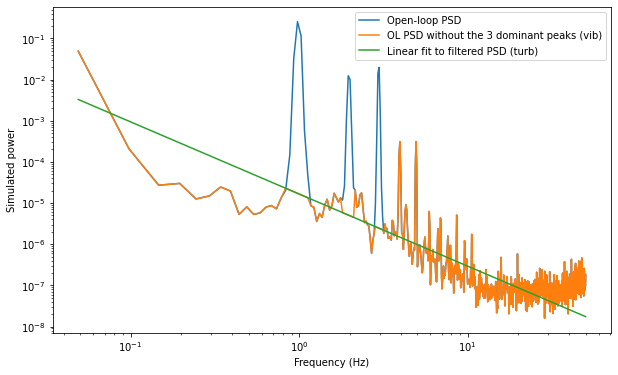

In [397]:
from functools import reduce
plt.figure(figsize=(10,6))
df = np.max(np.diff(freqs))
plt.loglog(freqs, psd, label="Open-loop PSD")
fcens = find_psd_peaks(freqs, psd, 3)
mask = reduce(np.logical_or, [np.abs(freqs - fcen) < 4 * df for fcen in fcens])
psd_novib = copy(psd)
psd_novib[mask] = np.exp(slope * np.log(freqs[mask]) + intercept)
plt.loglog(freqs, psd_novib, label="OL PSD without the 3 dominant peaks (vib)")
plt.loglog(freqs, np.exp(slope * np.log(freqs) + intercept), label="Linear fit to filtered PSD (turb)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Simulated power")
plt.savefig("../figures/psd_fit.pdf")